In [ ]:
# Problem 1 - Load the data

import pandas as pd
df = pd.read_csv('sales_data_sample.csv', encoding = "unicode_escape")
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107.0,30,95.70,2,2871.00,2/24/03 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121.0,34,81.35,5,2765.90,5/7/03 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134.0,41,94.74,2,3884.34,7/1/03 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145.0,45,83.26,6,3746.70,8/25/03 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159.0,49,100.00,14,5205.27,10/10/03 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [ ]:
# Problem 2 - Are there Duplicates?
duplicate_count = df.duplicated().sum()
print(duplicate_count)

# Remove Duplicates
df.drop_duplicates(inplace = True)

# Double Check duplicates are removed
duplicate_count = df.duplicated().sum()
print(duplicate_count)

2
0


In [ ]:
# Problem 3 - For each column, is there any NaN value?
missing_count = df.isna().sum()
print(f'Number of missing values in each column:\n{missing_count}')
# How do you plan to fill those NaN values? Explain your reasoning and approach. If you decided to leave NaN as it is, please also explain your reasoning.
# Order Number -> We will drop these 5 entries because these are likely unique identifiers for each row of data, and the missing values represent less than 0.1% of total data. We should take an action item to investigate upstream how can unique identifier information be empty
# Address Line 2 -> Leave it alone, because Address Line 1 likely contains the important address information. Address Line row 2 is rarely used as expected.
# State -> We will keep these rows in the data because the city + postal code combination should allow us to infer the state for all but 77 rows of data.
# ZipCode -> We won't drop these rows, however, if we are conducting any geographic based analysis we won't use this data. If advanced location tools exist at our current company, this can be determined by combination of Address Line 1 and City.
# Territory -> It is expected that Territory is missing for some geographies. ZipCode and City will allow geographical analysis if needed.
# DealSize -> Go back to the data team (once members recover) and ask them to fill out dealsize for each of the rows based on the business rule thresholds for all other records. For now, delivering few of these values missing to data science team should not hinder Data Science projects.
df.info()

Number of missing values in each column:
ORDERNUMBER            5
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2522
CITY                   0
STATE               1486
POSTALCODE            77
COUNTRY                0
TERRITORY           1075
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               4
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 2824 entries, 0 to 2825
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2819 non-null   float64
 1   QUANTITYORDERED   2824 non-null   int64  
 2   PRICEEACH         2824 non

In [ ]:
df_clean = df.dropna(subset=['ORDERNUMBER'])
df_clean.isna().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2517
CITY                   0
STATE               1483
POSTALCODE            76
COUNTRY                0
TERRITORY           1073
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               4
dtype: int64

In [ ]:
# Problem 4 - For each column, are there any outliers?
# We care about only a few of the columns with regards to outliers - QUANTITYORDERED, PRICEEACH, & SALES. Based on the data inspection, SALES is also roughly a product of quantity and price (more on this in next problem). Thus, SALES outliers, if any, will be removed by treating outliers oamongn quantity or price data.

# If so, prove your point by creating visualizations of your choice.
import matplotlib.pyplot as plt

def plotHistogram(df, column):
    plt.hist(df[column], bins=50, color='blue', edgecolor='black')
    plt.title('Histogram of ' + column)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

plotHistogram(df_clean, 'QUANTITYORDERED')
# We will investigate this column further

plotHistogram(df_clean, 'PRICEEACH')
# Unusual spike in frequency of  100 units and lack of any data above 100, more on this in next problem

plotHistogram(df_clean, 'SALES')

# Is it reasonable to remove them? Provide your reasoning.
# We believe we should remove the outliers for the QUANTITYORDERED using the IQR method, then it will autocorrect some of the skewed data we are seeing for the SALES column as well.

Q1 = df_clean['QUANTITYORDERED'].quantile(0.25)
Q3 = df_clean['QUANTITYORDERED'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('lower_bound = ' + str(lower_bound) + ', upper_bound = ' + str(upper_bound))

df_clean_no_outlier = df_clean[(df_clean['QUANTITYORDERED'] >= lower_bound) & (df_clean['QUANTITYORDERED'] <= upper_bound)]
df_clean_no_outlier.head()


In [ ]:
#Verify Quantity data histogram after we removed outliers
plotHistogram(df_clean_no_outlier, 'QUANTITYORDERED')

In [ ]:
# Problem 5
# Knowing this treatment of PRICEEACH data, we can consider price data inaccurate. We will overwrite the data entries with calculated number Price = Sales / Quantity. We are assuming trustworthines of Quantity and Sales data.
df_clean_no_outlier['PRICEEACH'] = df_clean_no_outlier['SALES'] / df_clean_no_outlier['QUANTITYORDERED']
df_clean_no_outlier.head()

/var/folders/67/7pq168cs5qj3w3m5j71h1r280000gn/T/ipykernel_45307/1087633635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_no_outlier['PRICEEACH'] = df_clean_no_outlier['SALES'] / df_clean_no_outlier['QUANTITYORDERED']


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107.0,30,95.70,2,2871.00,2/24/03 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121.0,34,81.35,5,2765.90,5/7/03 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134.0,41,94.74,2,3884.34,7/1/03 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145.0,45,83.26,6,3746.70,8/25/03 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159.0,49,106.23,14,5205.27,10/10/03 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


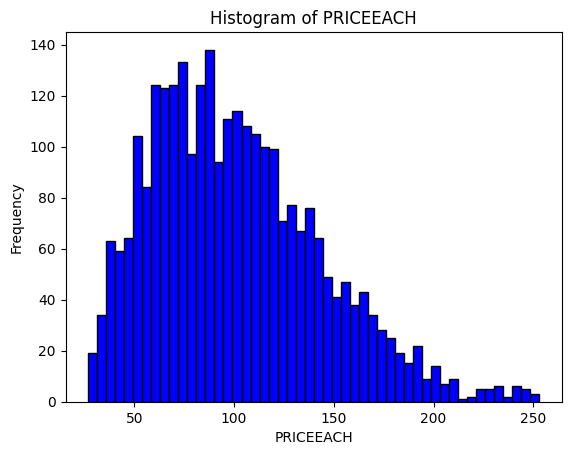

In [ ]:
#Verify successful data modification but inspecting new histogram of PRICEEACH column post-treatment
plotHistogram(df_clean_no_outlier, 'PRICEEACH')

In [ ]:
# Problem 6 - Determine / correct data types
print(df_clean_no_outlier.dtypes)
df_clean_no_outlier.head()
# From our inspection we don't see any strong datatype mismatches. We decide to reformat the ORDERDATE column to match a standard date format that might be later more useful for analysi althought Year, Month and Qtr columns are already available for time-based insights.
df_final = df_clean_no_outlier.copy()
df_final['ORDERDATE'] = pd.to_datetime(df_final['ORDERDATE'], infer_datetime_format=True)
# Verify ORDERDDATE column has been reformated
df_final.head()
# We could further update some of the data types from 64bit to 32bit if there was a concern with compute power or storage in the downstream systems. We have made an assumption these constraints are not present

In [ ]:
# Problem 6 - xport the final data frame to a CSV file.
df_final.to_csv('final.csv')